In [48]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
import torch

## Using colab?

In [ ]:
colab = False
token = ""
repo_owner = ""
repo_name = "PTL-PINNS"

In [50]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /content/{repo_name}
    !ls
    !pip install -e .
    %cd ..

from ptlpinns.models import load, model, training
from ptlpinns.odes import forcing, equations, numerical

      Successfully uninstalled ptlpinns-1.0.0
/content
Directory 'PTL-PINNS' already exists; skipping git clone.
/content/PTL-PINNS
figures  LICENSE  ptlpinns  pyproject.toml  README.md
Obtaining file:///content/PTL-PINNS
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ptlpinns (pyproject.toml) ... done
  Created wheel for ptlpinns: filename=ptlpinns-1.0.0-py3-none-any.whl size=4438 sha256=9355a2db75fb8b4009ce2f08959931e4a31b396391dc6a422655018a1a3acb48
  Stored in directory: /tmp/pip-ephem-wheel-cache-h913ssbi/wheels/2b/14/37/f86a63c4ba30a198a2880507af25191d7dbc3607a1fc057f81
Successfully built ptlpinns
  Attempting uninstall: ptlpinns
    Found existing installation: ptlpinns 1.0.0
    Uninstalling ptlpinns-1.0.0:
      Successfully uninstalled ptlpinns-1.0.0
/

## Training equations

In [ ]:
conf = load.ptl_config("/content/PTL-PINNS/ptlpinns/train/config/undamped.yaml")

# save log
os.makedirs(conf["experiment"], exist_ok = True)
with open(f'{conf["experiment"]}/training_log.json', 'w') as f:
    json.dump(conf, f)

# load values
N = conf["N"]
t_span = (0, conf["t_max"])
t_eval = np.linspace(t_span[0], t_span[1], N)
k, w_list, forcing_freq, forcing_coef = conf["k"], conf["w_list"], conf["forcing_freq"], conf["forcing_coef"]
ic_python_list = conf["ic_python_list"]
ic_list = [load.initial_condition(y1_0=ic[0], y2_0=ic[1]) for ic in ic_python_list]

In [ ]:
# define forcing: sum of cosine functions
forcing_list_numpy = [forcing.sum_cosine_forcing(numpy=True, w_0=omega_list, coeff=coeff_list)
                      for omega_list, coeff_list in zip(forcing_freq, forcing_coef)]

forcing_list_torch = [forcing.sum_cosine_forcing(numpy=False, w_0=omega_list, coeff=coeff_list)
                      for omega_list, coeff_list in zip(forcing_freq, forcing_coef)]

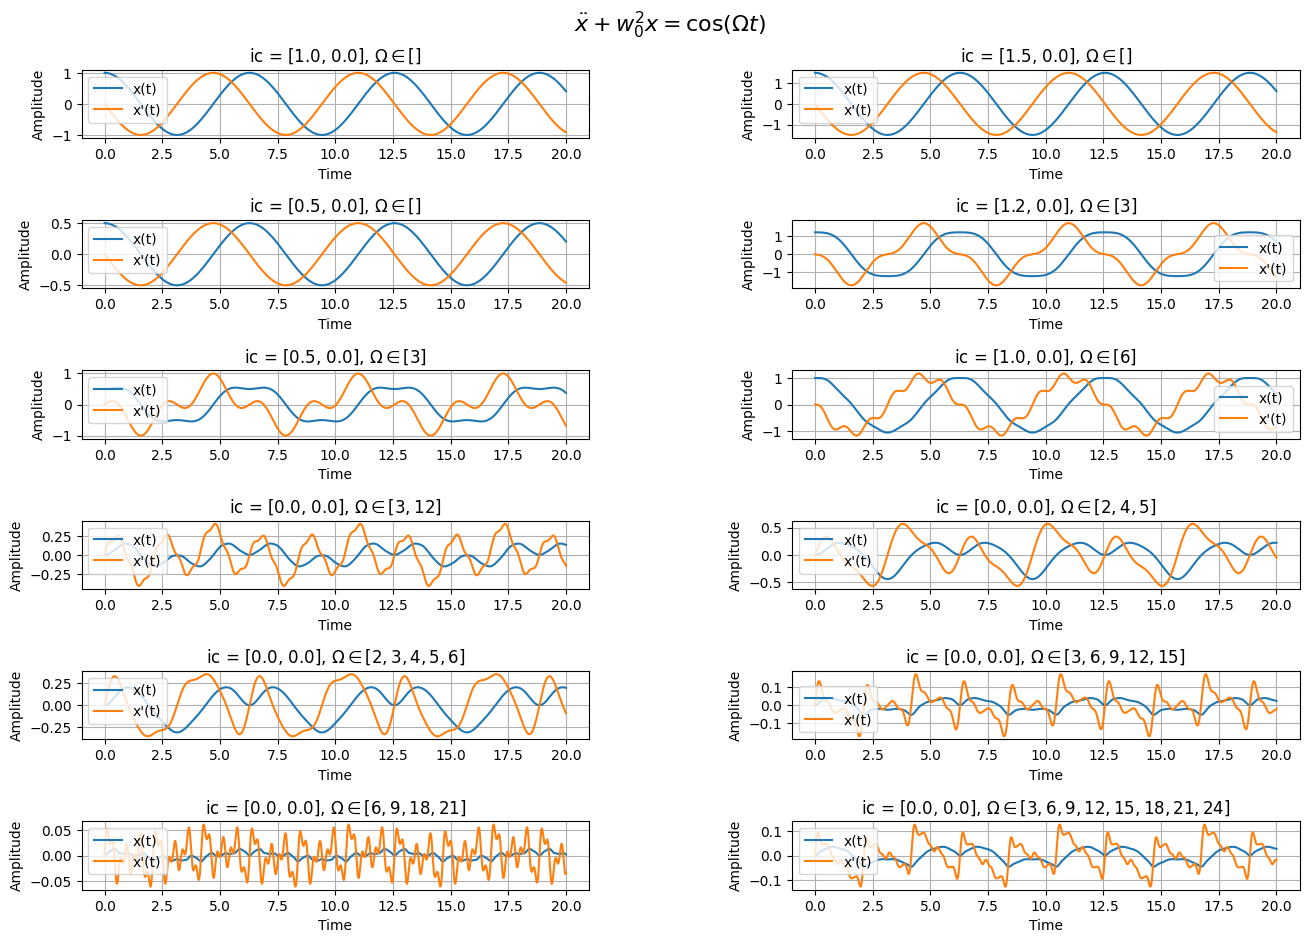

In [69]:
# returns 2D linear equation functions
linear_equation_functions_np = [equations.ode_oscillator(forcing_list_numpy[k],
                                                    w_0=w_list[k],
                                                    epsilon=0, numpy=True)
                                                    for k in range(k)]

# solves the 2D linear equation functions
title_list = [rf"ic = {ic_python_list[i]}, $\Omega \in {forcing_freq[i]}$"
              for i in range(k)]

linear_solution_list = [numerical.solve_ode_equation(linear_equation_functions_np[index], t_span, t_eval, ic_python_list[index]) for index in range(k)]

# visualize the solutions of the training equations
numerical.plot_multiple_ode_solutions(linear_solution_list,
                                       t_eval, titles=title_list,
                                       suptitle=r"$\ddot{x} + w^2_0 x = \cos(\Omega t)$", hspace = 1.2)

## Model Configuration

In [ ]:
use_sine, use_fourier, n_frequencies, scale, bias = conf["use_sine"], conf["use_fourier"], conf["n_frequencies"], conf["scale"], conf["bias"]
hidden_layers, num_iter, learning_rate = conf["hidden_layers"], conf["num_iter"], conf["lr"]
step_size, gamma, method = conf["step_size"], conf["gamma"], conf["method"]
ode_weight, ic_weight = conf["w_ode"], conf["w_ic"]


# define model
pinn = model.Multihead_model_fourier(k, use_sine=use_sine, use_fourier=use_fourier, n_frequencies=n_frequencies,
                                      scale=scale, bias=bias, HIDDEN_LAYERS=hidden_layers)

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn.to(dev)

Multihead_model_fourier(
  (fourier): FourierFeatures()
  (linear1): SineLayer(
    (linear): Linear(in_features=32, out_features=256, bias=True)
  )
  (linear2): SineLayer(
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-11): 12 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [71]:
every=100
save_epoch=100
optimizer=torch.optim.Adam(pinn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Train Neural Network

In [ ]:
equation_functions = []
for i in range(k):
    equation_functions.append(equations.equation_oscillator(w_0=w_list[i], epsilon=0))

In [ ]:
loss_trace, ode_trace, ic_trace, result_trace = training.train(model=pinn, optimizer=optimizer, num_iter=num_iter, equation_functions=equation_functions,
                                                      initial_condition_functions=ic_list, forcing_functions=forcing_list_torch,
                                                      N=N, t_span=t_span, every=every, save_epoch=save_epoch, ode_weight=ode_weight,
                                                      ic_weight=ic_weight, scheduler=scheduler, method=method)

  0%|          | 0/15000 [00:00<?, ?it/s]

100th Iter: total 0.03441943269077221, ode 0.03421466547813743, ic 0.0002047672126347811
200th Iter: total 0.00927367249079029, ode 0.009206771988522473, ic 6.690050226781718e-05
300th Iter: total 0.004269319701620781, ode 0.00422686520951291, ic 4.245449210787062e-05
400th Iter: total 0.003424328127110687, ode 0.0033884880722972023, ic 3.584005481348448e-05
500th Iter: total 0.0029989070748087255, ode 0.002969141998812986, ic 2.9765075995739335e-05
600th Iter: total 0.003547905442310135, ode 0.0035084345211550804, ic 3.947092115505461e-05
700th Iter: total 0.004242946754864075, ode 0.004196244377646733, ic 4.6702377217341674e-05
800th Iter: total 0.0025302300777804744, ode 0.002498683225955618, ic 3.154685182485643e-05
900th Iter: total 0.0021723093478789104, ode 0.002154692140202314, ic 1.761720767659645e-05
1000th Iter: total 0.0019257750076690477, ode 0.0019153060779971834, ic 1.046892967186428e-05
1100th Iter: total 0.0017578687627090993, ode 0.0017477963209103753, ic 1.0072441798

### View results and save

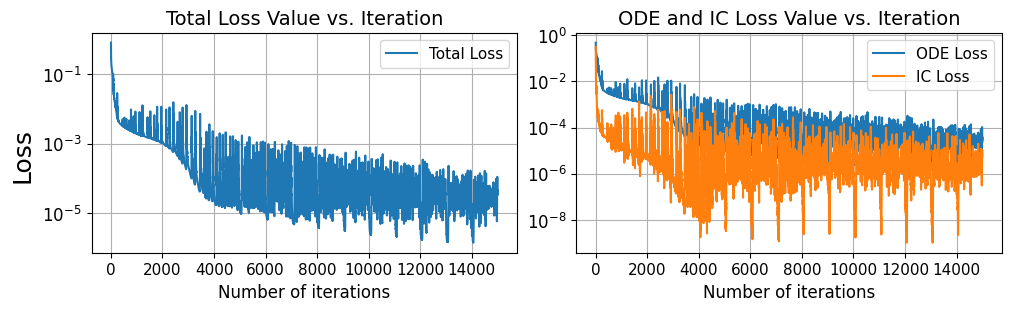

In [58]:
training.plot_loss(loss_trace, ode_trace, ic_trace, path=None)

In [ ]:
# compute the NN solutions
pinn.eval()
pinn.to('cpu')
NN_solution, _ = pinn(training.generate_eval_tensor(N=N, t_span=t_span, require_grad=False))
NN_solution = NN_solution.detach().numpy()

name = conf["experiment"]
torch.save(pinn.state_dict(), f"/content/PTL-PINNS/ptlpinns/models/train/{name}/model_{name}.pth")

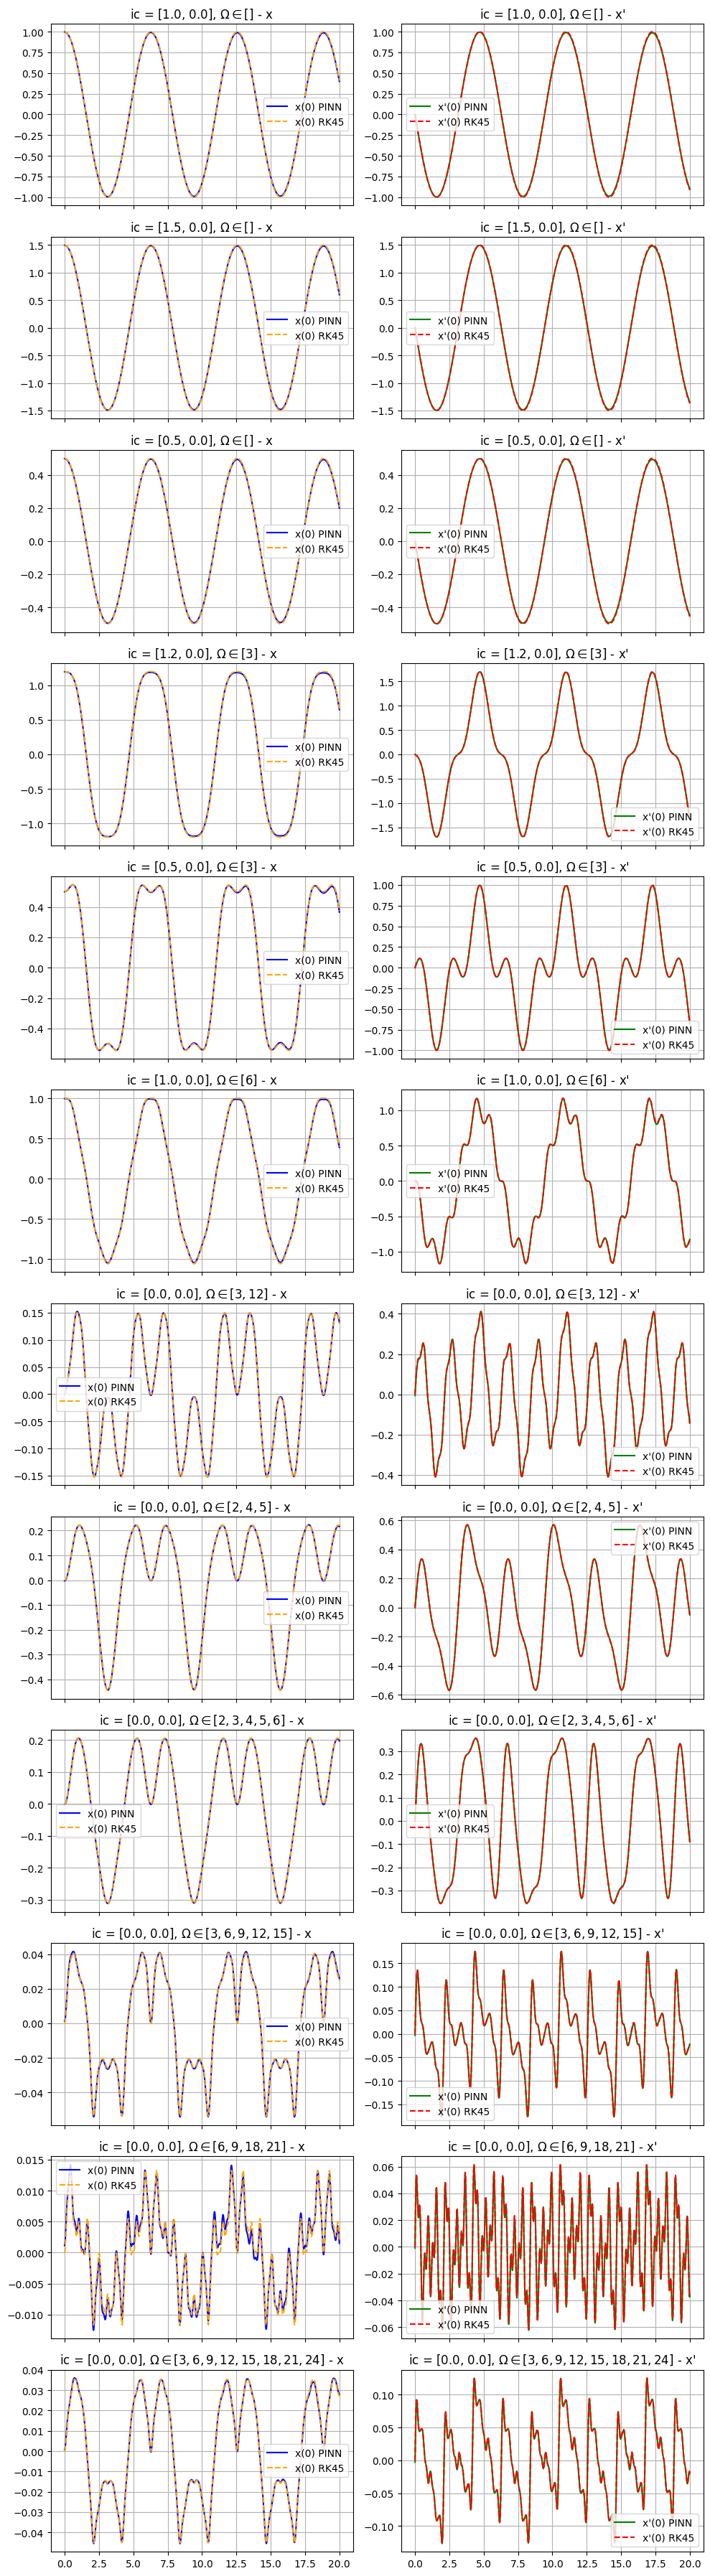

In [ ]:
training.compare_training_solutions(NN_solution, linear_solution_list, t_eval, title_list, k)